#                                       Knight ML Assignment 


## This is First NB where i did some cleaning of data and basic Analysis and Visualization. In second NB I did Pre-processing and Modelling.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
train.shape

(82657, 12)

In [5]:
from pandas_profiling import ProfileReport

ProfileReport(train, minimal=True)


 Observations :-
 1. 'user_name' has 19k (23%) missing points. 'designation' has 28% missing points. region_2 has 56% missing. We can drop region_2.
 2. Total 1lakh missing cells .
 3. 5k duplicate rows.
 4. This is a multi-class classification with imbalanced classes !/
 5. Price is Skewed heavily, have to normalize.

 
            

In [32]:
train.variety.value_counts()[:19:-1] # LOWEST fREQUENT CLASS LABELS !

Gamay                          758
Bordeaux-style White Blend     776
Gewürztraminer                 790
Pinot Grigio                   818
Portuguese White               833
Champagne Blend                917
Grüner Veltliner               973
Cabernet Franc                1027
Name: variety, dtype: int64

## Deduplication and Filling NANs

In [63]:
train.drop_duplicates(subset = {'review_title'} , keep = 'first' , inplace = True)
test.drop_duplicates(subset = {'review_title'} , keep = 'first' , inplace = True)

In [73]:
train = train.drop('region_2', axis = 1)
test = test.drop('region_2', axis = 1)

All province belong to same country , all Region 1 to same province and all winery to a province and all designation to same winery !!!

So We sort the Data by them and do FORWARD FILLING OF MISSING VALUES To get highest correct values

In [8]:
train = train.sort_values(by=['country' , 'province' , 'region_1' ,'winery' ] , ignore_index = True)

test = test.sort_values(by=['country' , 'province' , 'region_1' ,'winery' ] , ignore_index = True)

In [9]:
train.isna().sum() # All the sum of NAN Values by variables!

user_name             18451
country                  33
review_title              0
review_description        0
designation           22035
points                    0
price                  5207
province                 33
region_1              11932
winery                    0
variety                   0
dtype: int64

#### First we fill 'Designation' as it comes under every other features in the Sort and will be filled accurately!

In [10]:
train['designation'].fillna(method = 'ffill', inplace= True)

Now , Above Designation is the Winery which has no missing points. Above that is Region 1

In [11]:
train['region_1'].fillna(method = 'ffill', inplace= True)

Above that is the Province  

In [12]:
train['province'].fillna(method = 'ffill', inplace= True)

Above that is the country which has all the NAN values at the Last so we just fill it with most occurring i.e mode


In [13]:
train['country'] = train['country'].fillna(train['country'].mode()[0])

### For filling 'price' I did grouping the 'winery' and imputing mean values!

In [14]:
train[train['winery']== 'Chateau Ste. Michelle'].price

71894    18.0
71895    11.0
71896    10.0
71897    14.0
71898    28.0
         ... 
74225    16.0
74226    30.0
74227    28.0
74228    24.0
74229    15.0
Name: price, Length: 146, dtype: float64

#### As we can see , wine from a certain winery have similiar prices , so we will groupby 'winery' and take mean to fill prices!

In [74]:
train['price'] = train['price'].fillna(train.groupby('winery')['price'].transform('mean'))

For remaining Values , we will fill by simple mean !

In [75]:
train['price'].fillna((train['price'].mean()), inplace = True)

We fill the user_name by Forward Fill as most users have reviewed  wine from same country and we have very few counts of unique users so most of the NANs are same users !

In [17]:
train['user_name'].fillna(method = 'ffill', inplace= True)

Now lets see the NAN values in our data 

In [48]:
train.isna().sum() #So We have filled all NAN Values Now!

user_name             0
country               0
review_title          0
review_description    0
designation           0
points                0
price                 0
province              0
region_1              0
winery                0
variety               0
dtype: int64

### Doing the same for test data  !

In [50]:
test.isna().sum()  # MISSING VALUES IN TEST DATA !

user_name             4673
country                  0
review_title             0
review_description       0
designation           5888
points                   0
price                 1367
province                 3
region_1              3253
winery                   0
dtype: int64

In [52]:
test['designation'].fillna(method = 'ffill', inplace= True)

test['region_1'].fillna(method = 'ffill', inplace= True)

test['province'].fillna(method = 'ffill', inplace= True)

test['country'] = test['country'].fillna(test['country'].mode()[0])

test['price'] = test['price'].fillna(test.groupby('winery')['price'].transform('mean'))

test['price'].fillna((test['price'].mean()), inplace = True)

test['user_name'].fillna(method = 'ffill', inplace= True)

In [59]:
test.isna().sum() # After filling missing test values

user_name             0
country               0
review_title          0
review_description    0
designation           0
points                0
price                 0
province              0
region_1              0
winery                0
dtype: int64

So , Now we have filled all missing values in train and test data !

### DATA VISUALIZATION

Class Distribution

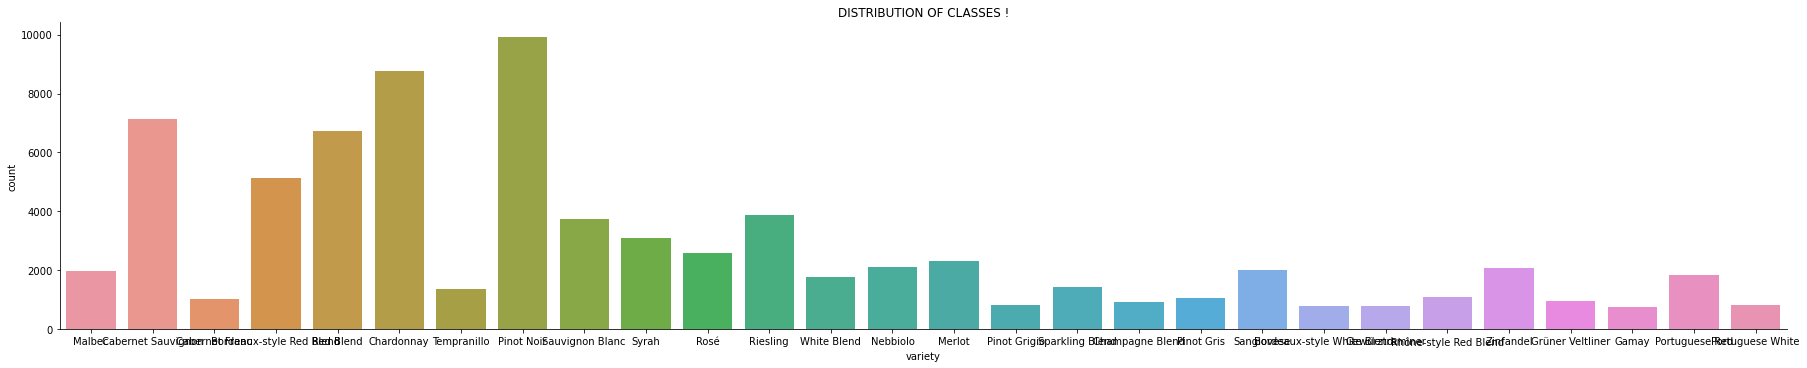

In [45]:
sns.catplot(x="variety",kind = 'count', aspect=5 , data= train)
plt.title('DISTRIBUTION OF CLASSES !');

    As we see , Some class dominate over others creating a Class imbalance !

In [57]:
len(train.variety.unique()) # No of unique Wine Varity !

28

In [52]:
train.variety.value_counts()[:1].sum() / train.variety.value_counts().sum() # Dominant Class

0.1288483022005144

In [63]:
train.variety.value_counts()[27].sum() / train.variety.value_counts().sum() # Least occuring Class

0.009846457613468083

#### The Most dominant wine is in almost 13% of data while least Frequent is just 0.9 % of Data !

#### Analyzing Distribution of price

(0.0, 500.0)

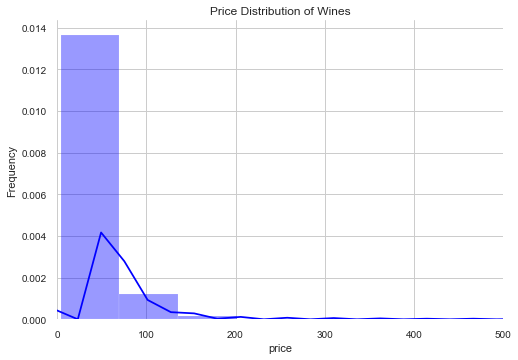

In [19]:
sns.set_style('whitegrid')

a = sns.distplot(train['price'] , color = 'b')
plt.title('Price Distribution of Wines')
a.set_ylabel('Frequency')
a.set_xlim(0,500)

We can see that most wines are below 200$ with few exceptions 

Text(0, 0.5, 'Percentage')

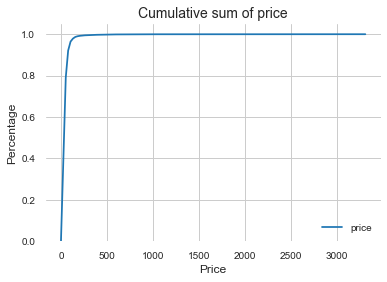

In [77]:
# CDF of price 

s = sns.kdeplot(train['price'] , cumulative = True )
plt.title('Cumulative sum of price' , size = 14)
plt.xlabel('Price' , size = 12)
plt.ylabel('Percentage' , size = 12)



OBS: Almost 95% of prices lie below 200$ 

Text(0.5, 1.0, 'Boxplot of Price distribution')

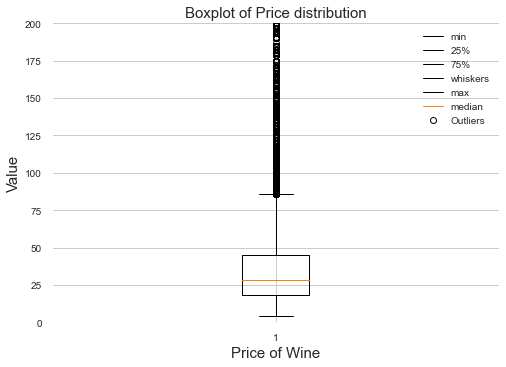

In [21]:
list = ['min', '25%'  , '75%' , 'whiskers', 'max' , 'median' , 'Outliers' ]
plt.boxplot(train['price'])
plt.legend(list)
plt.xlabel('Price of Wine' , size = 15)
plt.ylabel('Value' , size = 15)
plt.ylim(0,200)
plt.title('Boxplot of Price distribution' , size = 15)

Lots of wines are priced btw 20-45$ i.e lying btw 25 and 75 percentile! 

Now lets look at the points distribution !

Text(0.5, 1.0, 'Boxplot of Point distribution')

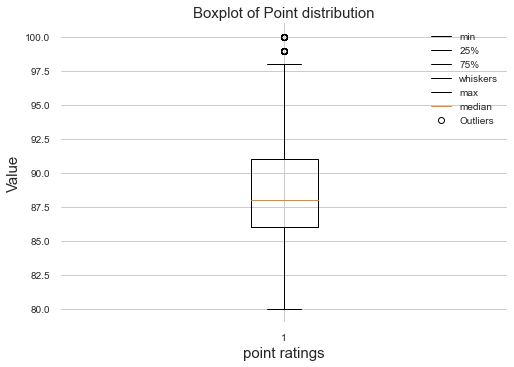

In [22]:
list = ['min', '25%'  , '75%' , 'whiskers', 'max' , 'median' , 'Outliers' ]
plt.boxplot(train['points'])
plt.legend(list)
plt.xlabel('point ratings' , size = 15)
plt.ylabel('Value' , size = 15)
plt.title('Boxplot of Point distribution' , size = 15)

WE see a majority of rating lies btw 86-91. With median at about 88. Only a select few wines have got a rating above 95. Lets see them!

In [78]:
best_wine = train[train['points']> 95] # Highest Rated Wines !

''

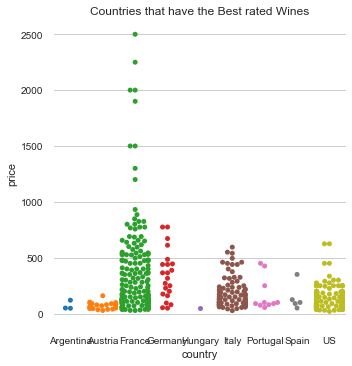

In [24]:
sns.catplot(x="country", y="price", kind="swarm", data=best_wine)
plt.title('Countries that have the Best rated Wines')
;

We see that the best rated wines come from France , italy ,Germany and US with France having the highest Priced

In [25]:
highest_price = train[train['price']> 200] #Costliest Wines

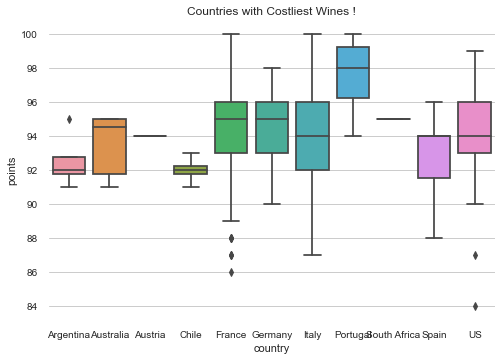

In [26]:
sns.boxplot(x="country", y="points", data=highest_price)
plt.title('Countries with Costliest Wines !') ;

### For the most expensive wines produced , Portugal has the best ratings followed by italy , germany , france ,US !

In [80]:
Cheap_wines =  train[train['price'] < 8] 

In [28]:
Cheap_wines.shape

(405, 11)

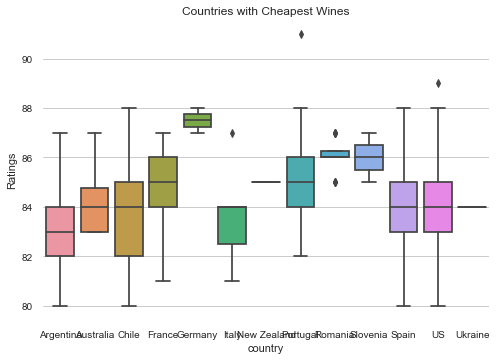

In [37]:
sns.boxplot(x="country", y="points", data= Cheap_wines)
plt.title('Countries with Cheapest Wines') 
plt.ylabel('Ratings') ;

Cheapest produced wines that have a good ratings comes from Germany , romania ,slovenia and france !

Text(0.5, 1.0, 'These wines are the cheapest(<5$)')

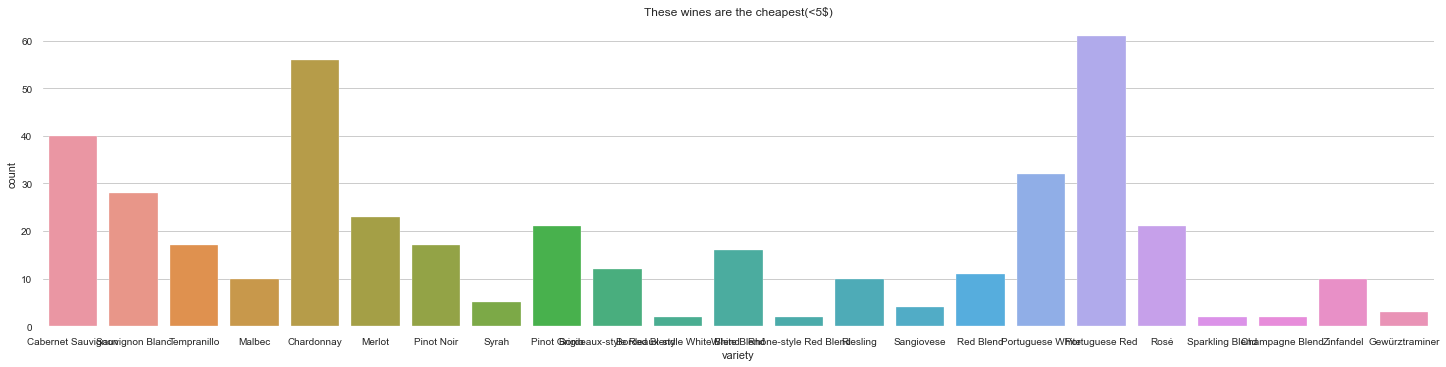

In [35]:
sns.catplot(x="variety",kind = 'count', aspect=4 , data= Cheap_wines)
plt.title('These wines are the cheapest(<5$)')


Text(0.5, 1.0, 'These wines are the Costliest(>800$)')

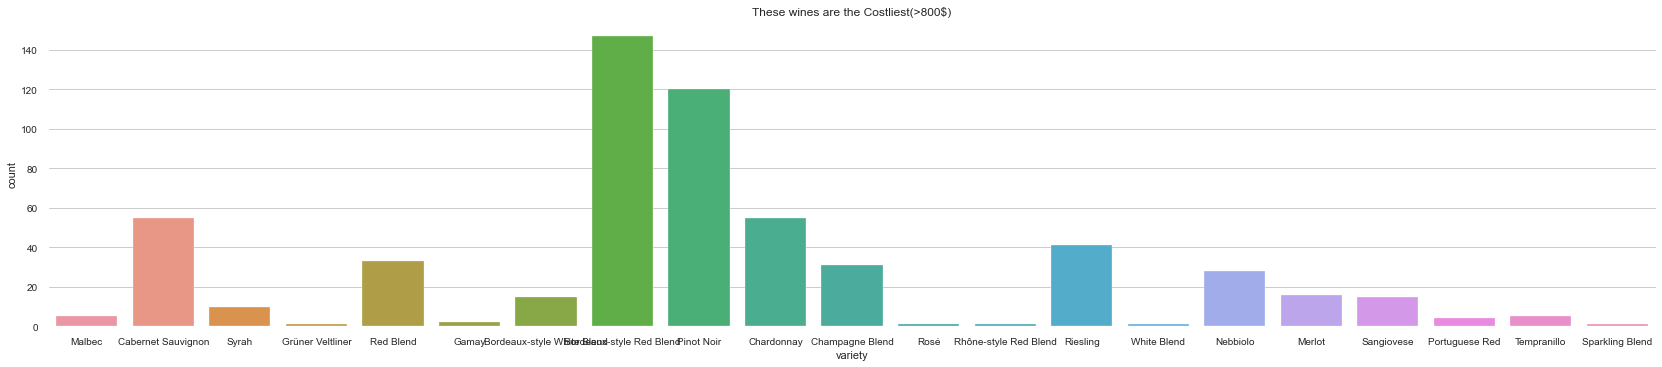

In [40]:
sns.catplot(x="variety", kind= 'count',aspect=4.6, data= highest_price)
plt.title('These wines are the Costliest(>800$)')

### One important thing to notice is that Chardonay and White Blend are among the cheapest as well as the costliest Wines ! Thus we can assume they come in every price range

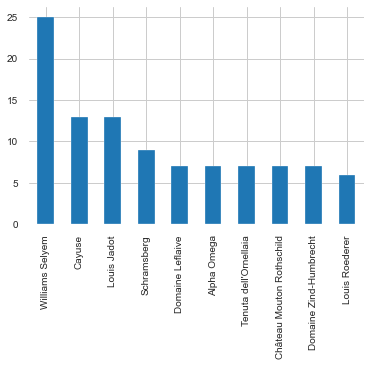

In [79]:
top_winery = best_wine.winery.value_counts()[:10] # Best rated winerys
top_winery.plot.bar()

We can see the most high rated wines come from Williams Selyem


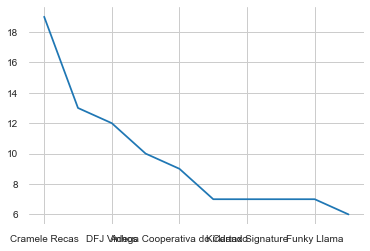

In [87]:
Cheap_wines.winery.value_counts()[:10].plot()

Cramele winery produces largest cheap wines

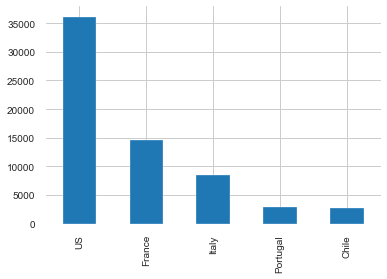

In [69]:
train.country.value_counts()[:5].plot.bar()

### US has the most Wines rated followed by France and Italy!

# TOP INSIGHTS FROM ANALYSIS 

## 1. Chardonay and white wines are the best rated among all price range.

## 2. Germany and France produces the best cheap wines.

## 3. Portugal's Costliest wines are extremely high rated among other countries' wines.

## 4. Cramele Winery Produces most amount of Cheap wines.

## 5. Williams Selyem winery produces the highest no. of best rated wines.


END OF NOTEBOOK 1